In [1]:
#import packages and formatting statements

import math
import numpy as np
from matplotlib import pyplot as plt
import astropy.io.fits as pyfits
from astropy.table import Table, join, Column, unique
from astropy.wcs import WCS
from astropy.io import ascii
import os
import pandas as pd
import seaborn as sns

# file extension
ext = "HA_FLUX_CORR"

#plotting specifics
sns.set_style("whitegrid")
# main palette
palette="rocket"
sns.set_palette(palette,10)
pal = sns.color_palette(palette,10)
colors = pal.as_hex()
#contrasting palette
pal_cont = sns.color_palette("mako", 5)
colors_cont = pal_cont.as_hex()

In [2]:
# Compile Galaxy, SNe, and intensity information
sne = Table.read('../Data/1.MUSE_SN_Sample.csv', format="csv")
ints = Table.read('../Data/1.sn_ints_exts.csv', format="csv")
sne_ints = join(sne, ints, keys=('Supernova'))
gals = Table.read('../Data/0.MUSEdata.csv', format='csv')
data = join(gals, sne_ints, keys=["Galaxy"])
data[0:6]

Galaxy,Distance,Gal_ra,Gal_dec,Pos_ang,Incl,r_eff,MUSE_nat_res,MUSE_phys_res,maps_musedap,maps_nat,maps_15asec,maps_150,maps_1kpc,maps_HII,maps_irac,maps_CO21,maps_eCO21,maps_ext,maps_vdisp,maps_HST,JWST200,JWST300,JWST335,JWST360,JWST770,JWST1000,JWST1130,JWST2100,Supernova,Type,SN_ra,SN_dec,In_Sample,sn_type,int_nat,int_150,int_1kpc,a_v,c_o,e_co,co_snr,co,halpha_lws,gcr,gcr_reff,met_theory
str7,float64,float64,float64,float64,float64,float64,float64,int64,str71,str58,str60,str64,str63,str50,str40,str72,str73,str36,str32,str45,str93,str93,str93,str93,str93,str94,str94,str94,str11,str12,float64,float64,str4,str5,float64,float64,float64,float64,float64,float64,float64,str3,float64,float64,float64,float64
NGC1087,15.85,41.60492,-0.498717,359.1,42.9,42.091877,0.92,84,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_Nat/NGC1087-0.92asec_MAPS.fits,../../GalaxyFiles/MUSELargeFiles/SFR/copt/NGC1087_sfr.fits,../../GalaxyFiles/MUSELargeFiles/SFR/15asec/NGC1087_sfr.fits,../../GalaxyFiles/MUSELargeFiles/SFR/copt/NGC1087_sfr_150pc.fits,../../GalaxyFiles/MUSELargeFiles/SFR/copt/NGC1087_sfr_1kpc.fits,../Data/HII_reg_masks/NGC1087_nebulae_mask_V2.fits,../Data/IRAC/ngc1087_irac1_atGauss4.fits,../../GalaxyFiles/ALMACO2-1/ngc1087_12m+7m+tp_co21_150pc_broad_mom0.fits,../../GalaxyFiles/ALMACO2-1/ngc1087_12m+7m+tp_co21_150pc_broad_emom0.fits,../Data/SFR_v1/NGC1087_MAPS_sfr.fits,../Data/vdisp/ngc1087_vdisp.fits,../../GalaxyFiles/HST/ngc1087_hst_ha_sic.fits,../../GalaxyFiles/JWSTLargeFiles/Anchored_8.0_Gauss7.5/ngc1087_F200W_atGauss7p5_anchored.fits,../../GalaxyFiles/JWSTLargeFiles/Anchored_8.0_Gauss7.5/ngc1087_F300W_atGauss7p5_anchored.fits,../../GalaxyFiles/JWSTLargeFiles/Anchored_8.0_Gauss7.5/ngc1087_F330W_atGauss7p5_anchored.fits,../../GalaxyFiles/JWSTLargeFiles/Anchored_8.0_Gauss7.5/ngc1087_F365W_atGauss7p5_anchored.fits,../../GalaxyFiles/JWSTLargeFiles/Anchored_8.0_Gauss7.5/ngc1087_F770W_atGauss7p5_anchored.fits,../../GalaxyFiles/JWSTLargeFiles/Anchored_8.0_Gauss7.5/ngc1087_F1000W_atGauss7p5_anchored.fits,../../GalaxyFiles/JWSTLargeFiles/Anchored_8.0_Gauss7.5/ngc1087_F1130W_atGauss7p5_anchored.fits,../../GalaxyFiles/JWSTLargeFiles/Anchored_8.0_Gauss7.5/ngc1087_F2100W_atGauss7p5_anchored.fits,SN1995V,II,41.61152777777777,-0.4987861111111111,True,II,8.839672735197591e+39,9.098356574390131e+39,5.626363456901733e+39,1.2788075992834158,10.1257905960083,0.9063823223114014,11.17165470123291,Yes,52.49597118323195,0.14295581272079702,3.396280301797827,8.241260378874152
NGC1300,18.99,49.920815,-19.411114,278.0,31.8,70.87826,0.89,83,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_Nat/NGC1300-0.89asec_MAPS.fits,../../GalaxyFiles/MUSELargeFiles/SFR/copt/NGC1300_sfr.fits,../../GalaxyFiles/MUSELargeFiles/SFR/15asec/NGC1300_sfr.fits,../../GalaxyFiles/MUSELargeFiles/SFR/copt/NGC1300_sfr_150pc.fits,../../GalaxyFiles/MUSELargeFiles/SFR/copt/NGC1300_sfr_1kpc.fits,../Data/HII_reg_masks/NGC1300_nebulae_mask_V2.fits,../Data/IRAC/ngc1300_irac1_atGauss4.fits,../../GalaxyFiles/ALMACO2-1/ngc1300_12m+7m+tp_co21_150pc_broad_mom0.fits,../../GalaxyFiles/ALMACO2-1/ngc1300_12m+7m+tp_co21_150pc_broad_emom0.fits,../Data/SFR_v1/NGC1300_MAPS_sfr.fits,../Data/vdisp/ngc1300_vdisp.fits,../../GalaxyFiles/HST/ngc1300_hst_ha_sic.fits,../../GalaxyFiles/JWSTLargeFiles/Anchored_8.0_Gauss7.5/ngc1300_F200W_atGauss7p5_anchored.fits,../../GalaxyFiles/JWSTLargeFiles/Anchored_8.0_Gauss7.5/ngc1300_F300W_atGauss7p5_anchored.fits,../../GalaxyFiles/JWSTLargeFiles/Anchored_8.0_Gauss7.5/ngc1300_F330W_atGauss7p5_anchored.fits,../../GalaxyFiles/JWSTLargeFiles/Anchored_8.0_Gauss7.5/ngc1300_F365W_atGauss7p5_anchored.fits,../../GalaxyFiles/JWSTLargeFiles/Anchored_8.0_Gauss7.5/ngc1300_F770W_atGauss7p5_anchored.fits,../../GalaxyFiles/JWSTLargeFiles/Anchored_8.0_Gauss7.5/ngc1300_F1000W_atGauss7p5_anchored.fits,../../GalaxyFiles/JWSTLargeFiles/Anchored_8.0_Gauss7.5/ngc1300_F1130W_atGauss7p5_anchored.fits,../../GalaxyFiles/JWSTLargeFiles/Anchored_8.0_Gauss7.5/ngc1300_F2100W_atGauss7p5_anchored.fits,SN2022acko,II,49.912458333

In [3]:
# homogonize and sort SN types

for i in range(len(data["Type"])):
    if "II" == data["Type"][i][:2]:
        data["Type"][i] = "II"
    elif "Ia" == data["Type"][i][:2]:
        data["Type"][i] = "Ia"
    elif data["Type"][i] == "I" or "U" == data["Type"][i][:1]:
        data["Type"][i] = "Unclassified"
    else:
        data["Type"][i] = "SESNe"

typeII_idx   = np.where(data["Type"]=="II")
typeIa_idx   = np.where(data["Type"]=="Ia")
typeIbc_idx  = np.where(data["Type"]=="SESNe")
typeUnc_idx  = np.where(data["Type"]=="Unclassified")

numTypeII  = len(typeII_idx[0])
numTypeIa  = len(typeIa_idx[0])
numTypeIbc = len(typeIbc_idx[0])
numTypeUnc = len(typeUnc_idx[0])

print("Type II: ",numTypeII)
print("Type Ia: ",numTypeIa)
print("SESNe: ",numTypeIbc)
print("Unclassified: ",numTypeUnc)
print(len(data))

Type II:  19
Type Ia:  6
SESNe:  5
Unclassified:  3
33


In [4]:
# get SN intensities by type
II_int  = data["int_nat"][typeII_idx]
Ia_int  = data["int_nat"][typeIa_idx]
Ibc_int = data["int_nat"][typeIbc_idx]
Unc_int = data["int_nat"][typeUnc_idx]


In [5]:
# get unique file names for each intensity
unique_gals = unique(data, keys='Galaxy')

int_nat_files  = unique_gals['maps_nat']
int_150_files  = unique_gals['maps_150']
int_1kpc_files = unique_gals['maps_1kpc']

In [6]:
# get pixel values for a galaxy map
def get_map_pixels(image, ext):
    
    #open fits and access map data
    hdulist  = pyfits.open(image)    
    map = hdulist[ext].data
    
    #flatten map and remove nans
    f_map = map.flatten()
    keep  = np.where(np.isfinite(f_map))
    pixels = f_map[keep]
    
    #return list of pixels
    return(pixels)

# compile pixels from all galaxy maps to a flattened list
def compile_maps(images, ext): 
    pixels = []
    
    #append finite pixels from each map
    for image in images:
        pixels.append(get_map_pixels(image, ext))
        
    #flatten into a single list
    pixels = np.hstack(pixels)    
    
    return(pixels)
    
#make ncdf from list of pixels
def make_ncdf(pixel_list):
    pixel_list.sort()
    cdf = np.cumsum(pixel_list)
    ncdf = cdf/cdf[-1]
    return(ncdf)

#make ncdf from list of galaxies
def make_gal_ncdf(images, ext):
    pixels = compile_maps(images,ext)
    ncdf = make_ncdf(pixels)
    return(ncdf)


In [7]:
# prep arrays for ncdf plot of SN intensities and all pixels at all res 
ncdf_nat_pix = make_gal_ncdf(int_nat_files, ext)
ncdf_nat_SNe = make_ncdf(data["int_nat"])
ncdf_150_pix = make_gal_ncdf(int_150_files, ext)
ncdf_150_SNe = make_ncdf(data["int_150"])
ncdf_1kpc_pix = make_gal_ncdf(int_1kpc_files, ext)
ncdf_1kpc_SNe = make_ncdf(data["int_1kpc"])


In [8]:
# Make ncdf plot for SN intensities and all pixels at all res 
# fig = plt.figure(figsize = (3,3))

# plt.xlabel("Percentile of H-alpha intensity")
# plt.ylabel("CDF f(<I_Halpha)")
# sns.ecdfplot(ncdf_nat_pix, ls="--",label="Native All Pixels")
# sns.ecdfplot(ncdf_nat_SNe, ls="-",label="Native SN sites")
# sns.ecdfplot(ncdf_150_pix, ls="--",label="150pc All Pixels")
# sns.ecdfplot(ncdf_150_SNe, ls="-",label="150pc SN sites")
# sns.ecdfplot(ncdf_1kpc_pix, ls="--",label="1kpc All Pixels")
# sns.ecdfplot(ncdf_1kpc_SNe, ls="-",label="1kpc SN sites")
# plt.legend(loc="best")
# plt.show()
# plt.close()

In [9]:
# functions to build NCR plot
def find_nearest(arr, x):
    difference_array = np.absolute(arr-x)
    index = difference_array.argmin()
    return(index)

def find_percentile(arr, index):
    percentile = index/float(len(arr))
    return(percentile)

def make_ncr(sn_arr,pix_arr):
    sn_per_arr,pix_per_arr = [0],[0]  # initialize at zero to make plot begin from 0,0

    sn_arr.sort()    
    pix_ncdf = make_ncdf(pix_arr)

    for i in range(len(sn_arr)):
        index = find_nearest(pix_arr, sn_arr[i])
        sn_per = find_percentile(sn_arr, i)
        sn_per_arr.append(sn_per + 1./len(sn_arr)) # add term to start appropiately and to end at 1.0
        pix_per = pix_ncdf[index]
        pix_per_arr.append(pix_per) 
        
    return(pix_per_arr, sn_per_arr)


In [10]:
# make NCR arrays for all SN intensities
pix_nat  = compile_maps(int_nat_files, ext)
pix_150  = compile_maps(int_150_files, ext)
pix_1kpc = compile_maps(int_1kpc_files, ext)

pix_per_arr_nat,  sn_per_arr_nat  = make_ncr(data['int_nat'],pix_nat)
pix_per_arr_150,  sn_per_arr_150  = make_ncr(data['int_150'],pix_150)
pix_per_arr_1kpc, sn_per_arr_1kpc = make_ncr(data['int_1kpc'],pix_1kpc)


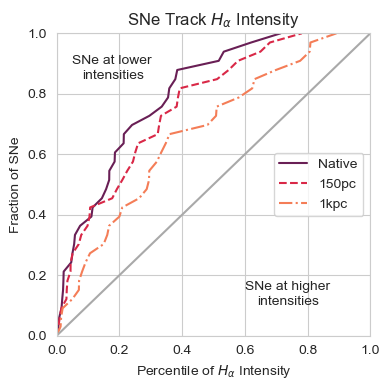

In [11]:
# NCR plot for SN intensities at different resolutions
fig = plt.figure(figsize = (4,4))

# add title and axis labels
plt.title(r"SNe Track $H_{\alpha}$ Intensity")
plt.xlabel(r"Percentile of $H_{\alpha}$ Intensity")
plt.ylabel("Fraction of SNe")

# plot CDFs
ax = sns.lineplot(x=pix_per_arr_nat,  y=sn_per_arr_nat, ls="-", color=colors[2],label="Native")
ax = sns.lineplot(x=pix_per_arr_150,  y=sn_per_arr_150, ls="--",color=colors[5],label="150pc")
ax = sns.lineplot(x=pix_per_arr_1kpc, y=sn_per_arr_1kpc, ls="-.",color=colors[7],label="1kpc")

# set up linestyles
# ax.lines[0].set_linestyle("-")
# ax.lines[1].set_linestyle("--")
# ax.lines[2].set_linestyle("-.")

# add clarifying text
ax.text(0.05, 0.9, "SNe at lower", fontsize=10)
ax.text(0.08, 0.85, "intensities", fontsize=10)
ax.text(0.6, 0.15, "SNe at higher",fontsize=10)
ax.text(0.64, 0.1, "intensities", fontsize=10)

#add 1-to-1 line
x = np.linspace(0,1,100)
y = x
ax.plot(x, y, ls="-", color="darkgrey")

plt.xlim(0,1.0)
plt.ylim(0,1.0)
plt.legend(loc="center right")
plt.tight_layout()
plt.savefig("../Figures/resolutionNCR.png", dpi=300)

In [12]:
# import model SN values
models = Table.read("../Data/1.model_sne_ints_dists.csv", format = "csv")
models[0:1]


int_mod_rand5,int_mod_rand1,int_mod_gas,int_mod_star,near_mod_rand5,near_mod_rand1,near_mod_gas,near_mod_star,r_5_ras,r_5_decs,r_1_ras,r_1_decs
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2.049847214205021e+39,8.467950720114223e+38,4.406642511284103e+40,8.962590334608703e+37,0.0,87.19202395277601,0.0,103.53290881873093,41.61225557832817,-0.4982705562180313,41.612144467577544,-0.5002150008527281


In [13]:
# function to evaluate the percentile shading for the distributions
# pull random intensity vals at locations of 33 model SNe numRuns times.    
# this builds up our confidence intervals for our results. 
def randomPull(modelArr, numSNe=33, numRuns=1000):
    allPulls_cdf, allPulls_x = [],[]
    # iterate over 1000 runs
    for i in range(numRuns):
        singlePulls = []
        # iterate over number of SNe
        for j in range(numSNe):
            # choose a random distance from model SNe
            val = np.random.choice(modelArr)
            singlePulls.append(val)
        # sort the model SNe distances and interpolate then save
        sortedPulls_y = np.sort(singlePulls)
        sortedPulls_x = np.linspace(0,len(sortedPulls_y),len(sortedPulls_y))/len(sortedPulls_y)
        x = np.linspace(0,len(sortedPulls_y),1000)/len(sortedPulls_y)
        y = np.interp(x, sortedPulls_x, sortedPulls_y)
        allPulls_x.append(y)
        allPulls_cdf.append(x)

    # Find the 1000 closest random pull values to each dist value in model SN array       
    allPer16Vals, allPer50Vals, allPer84Vals, cdfVals = [],[],[],[]
    for i in range(numSNe):
        SNlocVals = []
        targCDF = (i + 1.)/numSNe
        for j in range(numRuns):
#             find the actual distance value that is the closest to the generated model values 
            sim_CDF, sim_x = allPulls_cdf[j], allPulls_x[j]
            sim_at_targ = np.interp(targCDF,sim_CDF,sim_x)
            SNlocVals.append(sim_at_targ)    

    # now find 16-84th percentiles from each of these local distributions around x value    
        cdfVals.append(targCDF)
        locVals = np.sort(SNlocVals)
        per16Vals = np.percentile(locVals,16)
        allPer16Vals.append(per16Vals)
        per50Vals = np.percentile(locVals,50)     
        allPer50Vals.append(per50Vals)
        per84Vals = np.percentile(locVals,84)
        allPer84Vals.append(per84Vals)

    return(allPer16Vals, allPer50Vals, allPer84Vals, cdfVals)

In [14]:
# Make percentile CDFs for plotting
imr5 = [x for x in models["int_mod_rand5"] if math.isnan(x) == False]
imr1 = [x for x in models["int_mod_rand1"] if math.isnan(x) == False]
imgs = [x for x in models["int_mod_gas"] if math.isnan(x) == False]
imst = [x for x in models["int_mod_star"] if math.isnan(x) == False]

iSMm1_16, iSMm1_50, iSMm1_84, iSMm1_CDF  = randomPull(imr1)
iSMm5_16, iSMm5_50, iSMm5_84, iSMm5_CDF  = randomPull(imr5)
iSMm2_16, iSMm2_50, iSMm2_84, iSMm2_CDF  = randomPull(imgs)
iSMm3_16, iSMm3_50, iSMm3_84, iSMm3_CDF  = randomPull(imst)

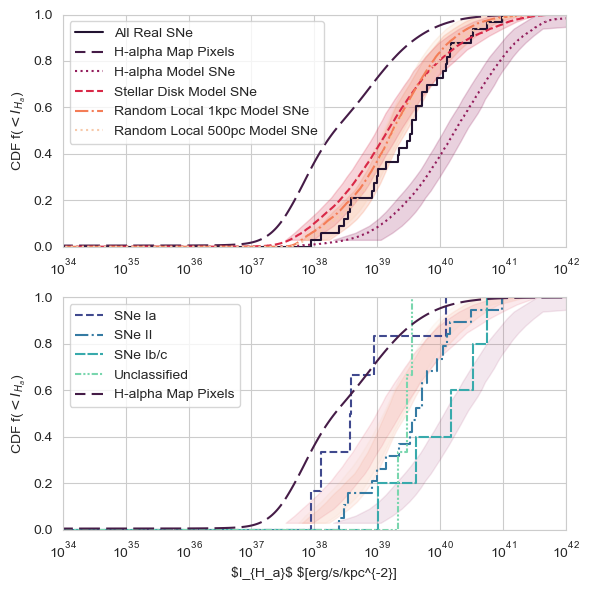

In [15]:
# model vs real CDFs for SN intensities 
fig,ax= plt.subplots(2, 1)   
fig.set_figheight(6)
fig.set_figwidth(6)

sns.ecdfplot(data["int_nat"].astype(float), label = "All Real SNe", ax=ax[0])
sns.ecdfplot(pix_nat.astype(float), label = "H-alpha Map Pixels", ax=ax[0], ls=(5,(10,3)))
sns.ecdfplot(models["int_mod_gas"].astype(float),   ls= ':',  label = "H-alpha Model SNe", ax=ax[0],color=colors[3])
sns.ecdfplot(models["int_mod_star"].astype(float),  ls= '--', label = "Stellar Disk Model SNe", ax=ax[0],color=colors[5])
sns.ecdfplot(models["int_mod_rand1"].astype(float), ls= '-.', label = "Random Local 1kpc Model SNe", ax=ax[0],color=colors[7])
sns.ecdfplot(models["int_mod_rand5"].astype(float), ls= ':',  label = "Random Local 500pc Model SNe", ax=ax[0],color=colors[9])
ax[0].fill_betweenx(y=iSMm2_CDF, x1=iSMm2_16,x2=iSMm2_84, alpha=0.2, color=colors[3])
ax[0].fill_betweenx(y=iSMm3_CDF, x1=iSMm3_16,x2=iSMm3_84, alpha=0.2, color=colors[5])
ax[0].fill_betweenx(y=iSMm5_CDF, x1=iSMm5_16,x2=iSMm5_84, alpha=0.2, color=colors[7])
ax[0].fill_betweenx(y=iSMm1_CDF, x1=iSMm1_16,x2=iSMm1_84, alpha=0.2, color=colors[9])
ax[0].legend(loc='best')
ax[0].set(xscale="log",ylabel =r'CDF f($<I_{H_a}$)', xlim=(1E34,1E42),ylim=(0,1.0))

sns.ecdfplot(Ia_int, label = "SNe Ia", ax=ax[1],ls="--", color=colors_cont[1])
sns.ecdfplot(II_int, label = "SNe II", ax=ax[1],ls="-.", color=colors_cont[2])
sns.ecdfplot(Ibc_int, label = "SNe Ib/c", ax=ax[1],ls=(0,(5,1)), color=colors_cont[3])
sns.ecdfplot(Unc_int, label = "Unclassified", ax=ax[1],ls=(0,(3,1,1,1,1,1)), color=colors_cont[4])
sns.ecdfplot(pix_nat.astype(float), label = "H-alpha Map Pixels", ax=ax[1], ls=(5,(10,3)), color=colors[1])
ax[1].fill_betweenx(y=iSMm2_CDF, x1=iSMm2_16,x2=iSMm2_84, alpha=0.1, color=colors[3])
ax[1].fill_betweenx(y=iSMm3_CDF, x1=iSMm3_16,x2=iSMm3_84, alpha=0.1, color=colors[5])
ax[1].fill_betweenx(y=iSMm5_CDF, x1=iSMm5_16,x2=iSMm5_84, alpha=0.1, color=colors[7])
ax[1].fill_betweenx(y=iSMm1_CDF, x1=iSMm1_16,x2=iSMm1_84, alpha=0.1, color=colors[9])
ax[1].set(xscale="log",ylabel =r'CDF f($<I_{H_a}$)', xlim=(1E34,1E42),ylim=(0,1.0),xlabel=r'$I_{H_a}$ $[erg/s/kpc^{-2}]')
ax[1].legend(loc='upper left')

plt.tight_layout()
fig.savefig("../Figures/IntensityCDFs.pdf", dpi=300)
plt.show()
plt.close()

In [16]:
# get the real SN sample's distances 
dist = Table.read("../Data/1.sn_hii_dists.csv", format='csv')
real_sn_dist = dist["hii_dist"]


In [17]:
# Here make CDFs of the distances from the generated SNe to the nearest HII regions

#distance CDFs
nm5 = [x for x in models["near_mod_rand5"] if math.isnan(x) == False]
nm1 = [x for x in models["near_mod_rand1"] if math.isnan(x) == False]
nmg = [x for x in models["near_mod_gas"] if math.isnan(x) == False]
nms = [x for x in models["near_mod_star"] if math.isnan(x) == False]

#dist
nSMm1_16, nSMm1_50, nSMm1_84, nSMm1_CDF = randomPull(nm1)
nSMm5_16, nSMm5_50, nSMm5_84, nSMm5_CDF = randomPull(nm5)
nSMmg_16, nSMmg_50, nSMmg_84, nSMmg_CDF = randomPull(nmg)
nSMms_16, nSMms_50, nSMms_84, nSMms_CDF = randomPull(nms)

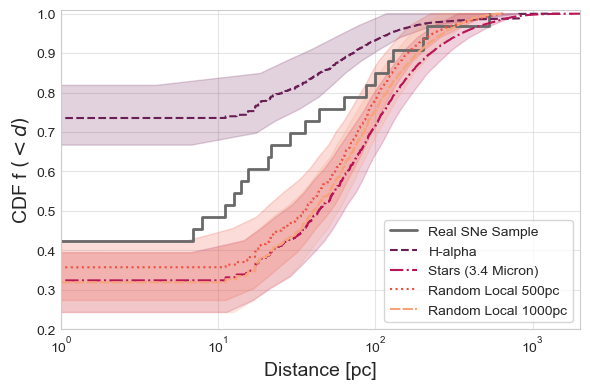

In [18]:
# Distance to nearest HII region plot
fig, ax = plt.subplots(1,1, figsize=(6,4))

sns.ecdfplot(real_sn_dist, color = "dimgrey",  label="Real SNe Sample", ax=ax,lw=2)
sns.ecdfplot(nmg, label="H-alpha", ls="--",lw=1.5,ax=ax, color=colors[2])
sns.ecdfplot(nms, label="Stars (3.4 Micron)", ls="-.",lw=1.5,ax=ax, color=colors[4])
sns.ecdfplot(nm5, label="Random Local 500pc", ls=":",ax=ax,lw=1.5, color=colors[6])
sns.ecdfplot(nm1, label="Random Local 1000pc", ls=(0,(5,1)),ax=ax,lw=1.5, color=colors[8])
ax.fill_betweenx(y=nSMmg_CDF, x1=nSMmg_16,x2=nSMmg_84, alpha=0.2, color=colors[2])
ax.fill_betweenx(y=nSMms_CDF, x1=nSMms_16,x2=nSMms_84, alpha=0.2, color=colors[4])
ax.fill_betweenx(y=nSMm5_CDF, x1=nSMm5_16,x2=nSMm5_84, alpha=0.2, color=colors[6])
ax.fill_betweenx(y=nSMm1_CDF, x1=nSMm1_16,x2=nSMm1_84, alpha=0.2, color=colors[8])

ax.set_xscale('log')
ax.set_ylim (0.2,1.01)
ax.set_xlim(1,2000)
ax.legend(loc='best')
ax.tick_params(axis = "both", which = "both", direction = "in")
plt.xlabel("Distance [pc]", fontsize = 14)
ax.set_ylabel(r"CDF f $(< d)$", fontsize = 14)
ax.grid(which='major', alpha=0.5)

plt.tight_layout()
fig.savefig("../Figures/ModelDistanceCDF.png", dpi=300)
plt.show()
plt.close()